In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Checking the installed version of TensorFlow.

tf.__version__

'2.8.2'

In [ ]:
# Testing to ensure GPU is being utilized.

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Deep Learning: Data Importing

**데이터 90753개**

1) UTKFace 데이터 : 24106개, 여러 국적 사람들의 이미지

2) Facial-age 데이터 : 9778개, 여러 국적 사람들의 이미지

3) All-Age-Faces 데이터 : 13322개, Asian 얼굴 이미지

4) Megaage-asian 데이터 : 43945개, Asian 얼굴 이미지

1) UTKFace 데이터, 2) Facial-age 데이터

구글 드라이브 -> Colab Notebooks/datasets 에 combined_faces.zip, images_filenames_labels_train.csv, images_filenames_labels_test.csv 에 넣기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1) UTKFace 데이터, 2) Facial-age 데이터가 합쳐진 데이터 불러오기
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Colab Notebooks/datasets/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Importing the training and testing datasets to create tensors of images using the filename paths.

train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_test.csv")

In [ ]:
df_two = pd.concat([train_df,test_df])
df_two

,filename,age,target
0,/content/content/combined_faces/18_369.jpg,18,2
1,/content/content/combined_faces/5_42.jpg,5,1
2,/content/content/combined_faces/5_204.jpg,5,1
3,/content/content/combined_faces/39_24.jpg,39,7
4,/content/content/combined_faces/22_41.jpg,22,3
...,...,...,...
10041,/content/content/combined_faces/26_51.jpg,26,4
10042,/content/content/combined_faces/26_50.jpg,26,4
10043,/content/content/combined_faces/74_7.jpg,74,10
10044,/content/content/combined_faces/60_53.jpg,60,9


3) All-Age-Faces 데이터

https://github.com/JingchunCheng/All-Age-Faces-Dataset
에서 다운로드 후 구글 드라이브 -> Colab Notebooks/datasets 에 파일 넣고 확인

aaf_data.xlsx 파일 가져오기

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/All-Age-Faces.zip'

-rw------- 1 root root 365164027 Jun  9 08:45 '/content/drive/My Drive/Colab Notebooks/datasets/All-Age-Faces.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/All-Age-Faces.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: All-Age-Faces Dataset/original images/08322A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08323A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08324A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08325A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08326A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08327A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08328A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08329A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08330A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08331A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08332A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08333A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08334A18.jpg  
  inflating: All-Age-Faces Dataset/original images/08335A18.jpg  
  inflating: All-Age-Faces Dataset/origi

In [ ]:
!ls -l

total 3012
-rw-r--r-- 1 root root  234555 Jun  9 11:55  aaf_data.xlsx
drwxr-xr-x 7 root root    4096 Feb 26  2019 'All-Age-Faces Dataset'
drwxr-xr-x 3 root root    4096 Jun  9 11:55  content
-rw-r--r-- 1 root root 2828329 Jun  9 11:55  df_mega.xlsx
drwx------ 5 root root    4096 Jun  9 11:55  drive
drwxr-xr-x 1 root root    4096 Jun  1 13:50  sample_data


In [ ]:
!ls -l 'All-Age-Faces Dataset'

total 1140
drwxr-xr-x 2 root root 385024 Feb 26  2019 'aglined faces'
drwxr-xr-x 2 root root   4096 Feb 26  2019  example
drwxr-xr-x 2 root root   4096 Feb 26  2019 'image sets'
drwxr-xr-x 2 root root 385024 Feb 26  2019 'key points'
drwxr-xr-x 2 root root 385024 Feb 26  2019 'original images'


In [ ]:
df_aaf = pd.read_excel('aaf_data.xlsx')
df_aaf

,img_name,gender,age,ethnicity
0,00000A02.jpg,1,2,2
1,00002A02.jpg,1,2,2
2,00004A02.jpg,1,2,2
3,00006A02.jpg,1,2,2
4,00008A02.jpg,1,2,2
...,...,...,...,...
13317,13312A80.jpg,0,80,2
13318,13314A80.jpg,0,80,2
13319,13316A80.jpg,0,80,2
13320,13318A80.jpg,0,80,2


In [ ]:
df_aaf['img_name'] = '/content/All-Age-Faces Dataset/original images/' + df_aaf['img_name'].astype(str)
df_aaf

,img_name,gender,age,ethnicity
0,/content/All-Age-Faces Dataset/original images...,1,2,2
1,/content/All-Age-Faces Dataset/original images...,1,2,2
2,/content/All-Age-Faces Dataset/original images...,1,2,2
3,/content/All-Age-Faces Dataset/original images...,1,2,2
4,/content/All-Age-Faces Dataset/original images...,1,2,2
...,...,...,...,...
13317,/content/All-Age-Faces Dataset/original images...,0,80,2
13318,/content/All-Age-Faces Dataset/original images...,0,80,2
13319,/content/All-Age-Faces Dataset/original images...,0,80,2
13320,/content/All-Age-Faces Dataset/original images...,0,80,2


4) Megaage-asian 데이터 : 43945개, Asian 얼굴 이미지

https://www.dropbox.com/s/x0gyfp12tozivjh/megaage_asian.zip?dl=0 에서 다운로드 후 구글 드라이브 -> Colab Notebooks/datasets 에 파일 넣고 확인

df_mega.xlsx 파일 가져오기

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/megaage_asian.zip'

-rw------- 1 root root 290421152 May 30 05:35 '/content/drive/My Drive/Colab Notebooks/datasets/megaage_asian.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/megaage_asian.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: megaage_asian/train/5499.jpg  
  inflating: megaage_asian/train/55.jpg  
  inflating: megaage_asian/train/550.jpg  
  inflating: megaage_asian/train/5500.jpg  
  inflating: megaage_asian/train/5501.jpg  
  inflating: megaage_asian/train/5502.jpg  
  inflating: megaage_asian/train/5503.jpg  
  inflating: megaage_asian/train/5504.jpg  
  inflating: megaage_asian/train/5505.jpg  
  inflating: megaage_asian/train/5506.jpg  
  inflating: megaage_asian/train/5507.jpg  
  inflating: megaage_asian/train/5508.jpg  
  inflating: megaage_asian/train/5509.jpg  
  inflating: megaage_asian/train/551.jpg  
  inflating: megaage_asian/train/5510.jpg  
  inflating: megaage_asian/train/5511.jpg  
  inflating: megaage_asian/train/5512.jpg  
  inflating: megaage_asian/train/5513.jpg  
  inflating: megaage_asian/train/5514.jpg  
  inflating: megaage_asian/train/5515.jpg  
  inflating: megaage_asian/train/5516.jpg  
  inflating: megaage_asian/train/5517.jpg  


In [ ]:
df_mega = pd.read_excel('df_mega.xlsx')
df_mega

,age,filename,dis
0,18,/content/megaage_asian/train/1.jpg,2.519484e-21 2.569943e-19 2.041559e-17 1.26306...
1,1,/content/megaage_asian/train/2.jpg,1.674574e-01 1.981500e-01 2.112185e-01 1.98150...
2,9,/content/megaage_asian/train/3.jpg,3.716799e-07 3.995936e-06 3.345756e-05 2.18170...
3,8,/content/megaage_asian/train/4.jpg,3.995938e-06 3.345758e-05 2.181708e-04 1.10796...
4,30,/content/megaage_asian/train/5.jpg,6.748783e-54 1.382677e-50 2.206189e-47 2.74151...
...,...,...,...
43940,5,/content/megaage_asian/test/3941.jpg,1.108530e-03 4.384320e-03 1.350466e-02 3.23959...
43941,5,/content/megaage_asian/test/3942.jpg,1.108530e-03 4.384320e-03 1.350466e-02 3.23959...
43942,7,/content/megaage_asian/test/3943.jpg,3.345785e-05 2.181726e-04 1.107972e-03 4.38211...
43943,8,/content/megaage_asian/test/3944.jpg,3.995938e-06 3.345758e-05 2.181708e-04 1.10796...


5) 나이 분류 추가

0-9세 / 10-19세 / 20-29세 / 30-39세 / 40-49세 / 50-59세 / 60-69세 / 70세-

In [ ]:
#나이 분류 추가

def class_labels(age):
    if 0 <= age <= 9:
        return 0
    elif 10 <= age <= 19:
        return 1
    elif 20 <= age <= 29:
        return 2
    elif 30 <= age <= 39:
        return 3
    elif 40 <= age <= 49:
        return 4
    elif 50 <= age <= 59:
        return 5
    elif 60 <= age <= 69:
        return 6
    else:
        return 7

In [ ]:
df_two = df_two.drop(['target'], axis = 1)
df_two

,filename,age
0,/content/content/combined_faces/18_369.jpg,18
1,/content/content/combined_faces/5_42.jpg,5
2,/content/content/combined_faces/5_204.jpg,5
3,/content/content/combined_faces/39_24.jpg,39
4,/content/content/combined_faces/22_41.jpg,22
...,...,...
10041,/content/content/combined_faces/26_51.jpg,26
10042,/content/content/combined_faces/26_50.jpg,26
10043,/content/content/combined_faces/74_7.jpg,74
10044,/content/content/combined_faces/60_53.jpg,60


In [ ]:
# Creating a new dataframe to hold all filenames, corresponding ages and class labels.

df_two_age = pd.DataFrame()
df_two_age['filename'] = df_two['filename']
df_two_age['age'] = df_two['age']
df_two_age['target'] = df_two['age'].map(class_labels)

df_two_age.head()

,filename,age,target
0,/content/content/combined_faces/18_369.jpg,18,1
1,/content/content/combined_faces/5_42.jpg,5,0
2,/content/content/combined_faces/5_204.jpg,5,0
3,/content/content/combined_faces/39_24.jpg,39,3
4,/content/content/combined_faces/22_41.jpg,22,2


In [ ]:
# Creating a new dataframe to hold all filenames, corresponding ages and class labels.

df_aaf_age = pd.DataFrame()
df_aaf_age['filename'] = df_aaf['img_name']
df_aaf_age['age'] = df_aaf['age']
df_aaf_age['target'] = df_aaf['age'].map(class_labels)

df_aaf_age.head()

,filename,age,target
0,/content/All-Age-Faces Dataset/original images...,2,0
1,/content/All-Age-Faces Dataset/original images...,2,0
2,/content/All-Age-Faces Dataset/original images...,2,0
3,/content/All-Age-Faces Dataset/original images...,2,0
4,/content/All-Age-Faces Dataset/original images...,2,0


In [ ]:
# Creating a new dataframe to hold all filenames, corresponding ages and class labels.

df_mega_age = pd.DataFrame()
df_mega_age['filename'] = df_mega['filename']
df_mega_age['age'] = df_mega['age']
df_mega_age['target'] = df_mega['age'].map(class_labels)

df_mega_age.head()

,filename,age,target
0,/content/megaage_asian/train/1.jpg,18,1
1,/content/megaage_asian/train/2.jpg,1,0
2,/content/megaage_asian/train/3.jpg,9,0
3,/content/megaage_asian/train/4.jpg,8,0
4,/content/megaage_asian/train/5.jpg,30,3


6) 데이터 합치기(90753)

In [ ]:
df_all = pd.concat([df_aaf_age,df_two_age, df_mega_age])
df_all

,filename,age,target
0,/content/All-Age-Faces Dataset/original images...,2,0
1,/content/All-Age-Faces Dataset/original images...,2,0
2,/content/All-Age-Faces Dataset/original images...,2,0
3,/content/All-Age-Faces Dataset/original images...,2,0
4,/content/All-Age-Faces Dataset/original images...,2,0
...,...,...,...
43940,/content/megaage_asian/test/3941.jpg,5,0
43941,/content/megaage_asian/test/3942.jpg,5,0
43942,/content/megaage_asian/test/3943.jpg,7,0
43943,/content/megaage_asian/test/3944.jpg,8,0


In [ ]:
#인덱스 다시 설정
df_all.reset_index(drop =False, inplace = True)
df_all = df_all.drop(['index'], axis = 1)
df_all

,filename,age,target
0,/content/All-Age-Faces Dataset/original images...,2,0
1,/content/All-Age-Faces Dataset/original images...,2,0
2,/content/All-Age-Faces Dataset/original images...,2,0
3,/content/All-Age-Faces Dataset/original images...,2,0
4,/content/All-Age-Faces Dataset/original images...,2,0
...,...,...,...
90748,/content/megaage_asian/test/3941.jpg,5,0
90749,/content/megaage_asian/test/3942.jpg,5,0
90750,/content/megaage_asian/test/3943.jpg,7,0
90751,/content/megaage_asian/test/3944.jpg,8,0


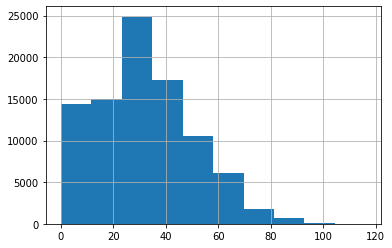

In [ ]:
# 데이터 분포 확인
df_all['age'].hist()

In [ ]:
# Shuffling the rows of combined_df so as to mix together the rows coming from both subreddit datasets.
df_all = shuffle(df_all, random_state=42).reset_index(drop=True)
df_all.head()

,filename,age,target
0,/content/All-Age-Faces Dataset/original images...,68,6
1,/content/content/combined_faces/38_315.jpg,38,3
2,/content/content/combined_faces/27_99.jpg,27,2
3,/content/megaage_asian/train/5888.jpg,1,0
4,/content/megaage_asian/train/35971.jpg,27,2


In [ ]:
#나이 분류별 데이터 수 확인
df_all['target'].value_counts()

2    23316
3    17144
0    12982
4    11387
1     9438
5     8893
6     4911
7     2682
Name: target, dtype: int64

In [ ]:
# Defining the filenames and ages from above master_df as X, and target as y for splitting into train and test datasets later.

X = df_all[['filename', 'age']]
y = df_all['target']

In [ ]:
# Splitting the dataset into training and testing datasets with test_size=0.3 and stratify=y. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(63527, 2)

In [ ]:
X_train.head()

,filename,age
86963,/content/content/combined_faces/71_8.jpg,71
78525,/content/megaage_asian/train/20502.jpg,57
67157,/content/All-Age-Faces Dataset/original images...,33
75541,/content/content/combined_faces/20_153.jpg,20
78259,/content/megaage_asian/train/3765.jpg,12


In [ ]:
X_test.shape

(27226, 2)

In [ ]:
X_test.head()

,filename,age
6468,/content/content/combined_faces/25_612.jpg,25
37292,/content/content/combined_faces/1_465.jpg,1
28059,/content/megaage_asian/train/19701.jpg,38
52695,/content/megaage_asian/train/38559.jpg,58
82778,/content/All-Age-Faces Dataset/original images...,74


In [ ]:
# Creating copies of X and y (both train and test) from above to create a dataframe of filepaths to all images and their target labels.
# These dataframes will be in the deep learning models later to create dataset input pipelines using TensorFlow.data.Dataset API.

temp_X_train = X_train.copy()
temp_X_train['target'] = y_train

temp_X_test = X_test.copy()
temp_X_test['target'] = y_test

In [ ]:
# Defining a function to append the filepath to each image name as a string.

combined_faces_path = "/content/content/combined_faces"

def append_path_to_filename(filename):
    return os.path.join(combined_faces_path, filename)

In [ ]:
# Mapping the above created function on both dataframes created above.

temp_X_train['filename'] = temp_X_train['filename'].map(append_path_to_filename)
temp_X_test['filename'] = temp_X_test['filename'].map(append_path_to_filename)

In [ ]:
# Exporting the above created dataframes as CSV files.

temp_X_train.to_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_train_one.csv", index=False)
temp_X_test.to_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_test_one.csv", index=False)

In [ ]:
# Importing the training and testing datasets to create tensors of images using the filename paths.

train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_train_one.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/images_filenames_labels_test_one.csv")

In [ ]:
train_df.head()

,filename,age,target
0,/content/content/combined_faces/71_8.jpg,71,7
1,/content/megaage_asian/train/20502.jpg,57,5
2,/content/All-Age-Faces Dataset/original images...,33,3
3,/content/content/combined_faces/20_153.jpg,20,2
4,/content/megaage_asian/train/3765.jpg,12,1


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/25_612.jpg,25,2
1,/content/content/combined_faces/1_465.jpg,1,0
2,/content/megaage_asian/train/19701.jpg,38,3
3,/content/megaage_asian/train/38559.jpg,58,5
4,/content/All-Age-Faces Dataset/original images...,74,7


In [ ]:
train_df.shape

(63527, 3)

In [ ]:
test_df.shape

(27226, 3)

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining the number of classes and a function to read, decode the image from given tensor and one-hot encode the image label class.

num_classes = 8

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

## Deep Learning: Classification Modelling

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-xxbdru75
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-xxbdru75
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=9a80077c8a0bd1e2ae21bab3519a1c9e20f68b5c433029e2ae43173af2a9ae02
  Stored in directory: /tmp/pip-ephem-wheel-cache-ik0c2pfz/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.5 MB/s 


In [ ]:
vggface = VGGFace(model='resnet50',
                  input_shape = (200, 200, 3))

165453824/165439116 [==============================] - 6s 0us/step


In [ ]:
vggface.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 100, 100, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 100, 100, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [ ]:
print('vggface 동결 전 훈련 가능 가중치의 종류:', len(vggface.trainable_weights))

vggface 동결 전 훈련 가능 가중치의 종류: 161


In [ ]:
from tensorflow.keras import models, layers

model1 = models.Sequential(name = 'VGGFace')
model1.add(vggface)

model1.add(layers.Flatten())
model1.add(layers.Dropout(0.4))
model1.add(layers.Dense(256, activation = 'relu'))
model1.add(layers.Dense(8, activation='softmax'))

In [ ]:
model1.summary()

Model: "VGGFace"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_resnet50 (Functiona  (None, 8631)             41246071  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 8631)              0         
                                                                 
 dropout (Dropout)           (None, 8631)              0         
                                                                 
 dense (Dense)               (None, 256)               2209792   
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 43,457,919
Trainable params: 43,404,799
Non-trainable params: 53,120
__________________________________________

In [ ]:
from tensorflow.keras import optimizers

model1.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.000005),
              metrics = ['accuracy'])

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the model.

vggface_history = model1.fit(train_dataset,
                        batch_size=32,
                        validation_data=test_dataset,
                        epochs=10,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/10
5956/5956 [==============================] - 1841s 305ms/step - loss: 1.9481 - accuracy: 0.3777 - val_loss: 1.7992 - val_accuracy: 0.4938
Epoch 2/10
5956/5956 [==============================] - 1811s 304ms/step - loss: 1.6831 - accuracy: 0.4276 - val_loss: 1.5223 - val_accuracy: 0.5296
Epoch 3/10
5956/5956 [==============================] - 1806s 303ms/step - loss: 1.4697 - accuracy: 0.4821 - val_loss: 1.2994 - val_accuracy: 0.5573
Epoch 4/10
5956/5956 [==============================] - 1801s 302ms/step - loss: 1.2969 - accuracy: 0.5436 - val_loss: 1.1368 - val_accuracy: 0.6239
Epoch 5/10
5956/5956 [==============================] - 1803s 303ms/step - loss: 1.1567 - accuracy: 0.5911 - val_loss: 1.0211 - val_accuracy: 0.6348
Epoch 6/10
5956/5956 [==============================] - 1821s 306ms/step - loss: 1.0491 - accuracy: 0.6253 - val_loss: 0.9587 - val_accuracy: 0.6440
Epoch 7/10
5956/5956 [==============================] - 1807s 303ms/step - loss: 0.9705 - accuracy: 0.6459

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss1 = vggface_history.history['loss']
test_loss1 = vggface_history.history['val_loss']
train_accuracy1 = vggface_history.history['accuracy']
test_accuracy1 = vggface_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of VGGFace model by epochs (using grayscale images)')

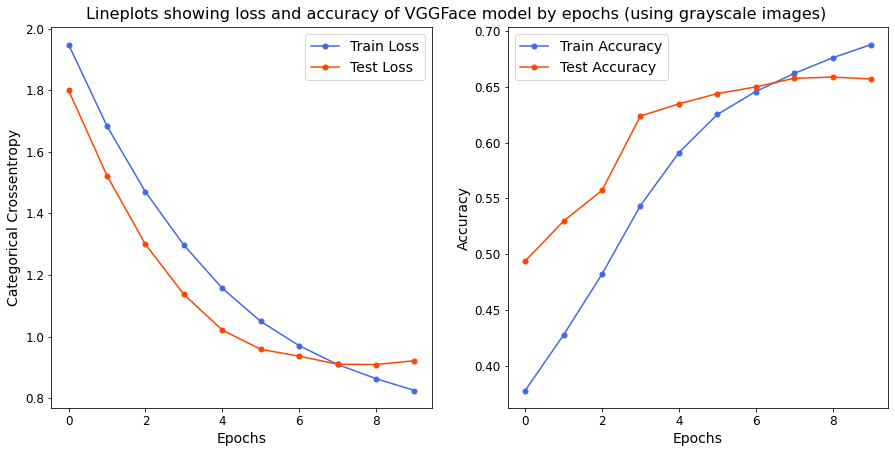

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss1, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss1, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy1, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy1, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGGFace model by epochs (using grayscale images)", fontsize=16)


In [ ]:
# Evaluating the model on test dataset.

vggface_score = model1.evaluate(test_dataset, verbose=1)

851/851 [==============================] - 64s 75ms/step - loss: 0.9217 - accuracy: 0.6572


In [ ]:
# Printing the relevant score summary.

vggface_labels = model1.metrics_names
print(f'VGGFace model {vggface_labels[0]} \t= {round(vggface_score[0], 3)}')
print(f'VGGFace model {vggface_labels[1]} \t= {round(vggface_score[1], 3)}')

VGGFace model loss 	= 0.922
VGGFace model accuracy 	= 0.657


In [ ]:
# Saving the model as a h5 file for possible use later.

model1.save('/content/drive/My Drive/Colab Notebooks/models/age_vggface_4.h5')

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 509562
-rw------- 1 root root 521791356 Jun  9 17:02 age_vggface_4.h5


In [ ]:
# Generating predictions from the model above.

vggface_pred = model1.predict(test_dataset)
vggface_pred = vggface_pred.argmax(axis=-1)

In [ ]:
len(cnn1_pred)

27226

In [ ]:
len(test_labels_list)

27226

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat1 = confusion_matrix(test_labels_list, cnn1_pred)
conf_mat1

array([[3604,  262,   25,    4,    4,    0,    4,    0],
       [ 265, 1543,  903,   71,   12,    3,    0,    0],
       [  10,  255, 5434, 1191,   67,    5,    2,    0],
       [   2,   16, 1388, 3008,  639,   60,    4,    0],
       [   1,    0,   92, 1013, 1800,  598,   20,    0],
       [   0,    0,    6,  113,  663, 1660,  239,    0],
       [   0,    2,    3,   12,   73,  512,  843,    0],
       [   0,    1,    0,    2,    4,   51,  737,    0]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

Normalized confusion matrix


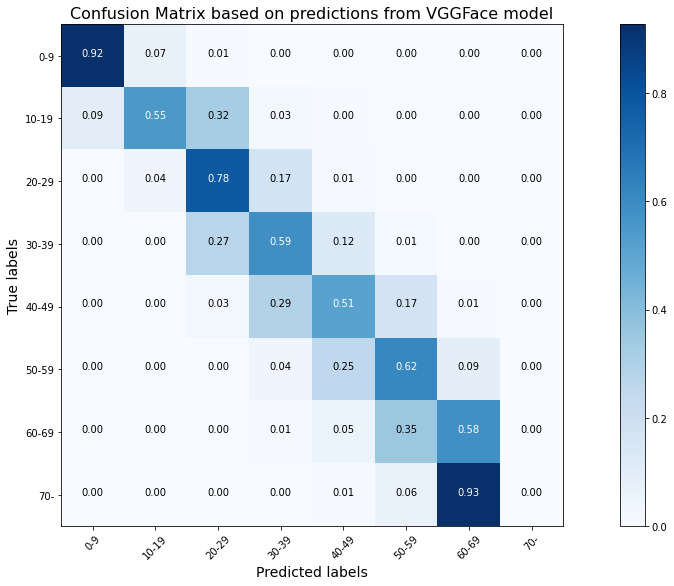

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-']


plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat1, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from VGGFace model"
                      #export_as="cnn1_conf_mat_norm"
                     )

plt.show()